In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jaxley as jx

from jaxley import Compartment
from jaxley_mech.channels.uiki96 import Leak, Kv, KA, KCa, Hyper, Ca, CaNernstReversal
from jaxley_mech.channels.fm97 import CaPump

# from jaxley_mech.channels.fm97 import Ca
from jaxley_mech.utils import prettify

from jax import config
config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

The calcium pump mechanim described in the papers are buggy. Here we revert to the NEURON style calcium pump (Fohlmeister & Miller, 1997). 

###  Voltage Clamp

### Figure 2D

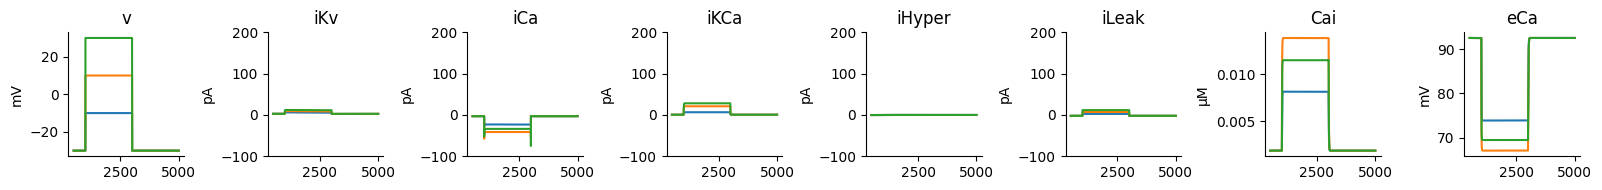

In [2]:
to_records = ["v", "iCa", "iKCa", "iLeak", "iHyper", 'iKv', "Cai", "eCa"]
mosaic = [["v", "iKv", "iCa", "iKCa", "iHyper", "iLeak", "Cai", 'eCa']]

params = {
    "length": 10,
    "radius": 5,
    "capacitance": 33.,
    "v": -30,
    "CaPump_taur": 10,
    "CaPump_cainf": 0.001,
    "Cao": 2.5,
}

fig, ax = plt.subplot_mosaic(mosaic, figsize=(16, 2))

V_steps = [-10, 10, 30] # depolarizing
for v_step in V_steps:

    cell = Compartment()
    cell.insert(Kv())
    cell.insert(KA())
    cell.insert(Hyper())
    cell.insert(Ca())
    cell.insert(KCa())
    cell.insert(CaPump())
    cell.insert(CaNernstReversal())
    cell.insert(Leak())

    for name, param in params.items():
        cell.set(name, param)

    cell.init_states()

    for rec in to_records:
        cell.record(rec, verbose=False)

    pre_vc_time = 1000  # ms
    vc_on_time = 2000  # ms
    total_time = 5000 # ms
    dt = 0.01 # ms, 
    time_steps = int(total_time / dt)

    v = jnp.zeros(time_steps) - 30.
    vc_on = int(pre_vc_time / dt)
    vc_off = int((pre_vc_time + vc_on_time) / dt)
    padding = int(500/dt)
    v = v.at[vc_on:vc_off].set(v_step)
    
    cell.clamp("v", v, verbose=False)

    s = jx.integrate(cell, delta_t=dt, t_max=total_time)
    s = prettify(s, to_records, dt)
    for i, rec in enumerate(to_records):
        ax[rec].set_title(rec)
        ax[rec].spines["top"].set_visible(False)
        ax[rec].spines["right"].set_visible(False)
        if rec == "CaPump_Cad" or rec == "Cas" or rec=="Cai":
            ax[rec].set_ylabel("μM")
            # ax[rec].set_ylim(0, 0.15)
            ax[rec].plot(s["time"][vc_on-padding:vc_off+int(2500/dt)], s[rec][vc_on-padding:vc_off+int(2500/dt)])

        elif rec == "v" or rec == "eCa":
            ax[rec].set_ylabel("mV")
            ax[rec].plot(s["time"][vc_on-padding:vc_off+int(2500/dt)], s[rec][vc_on-padding:vc_off+int(2500/dt)])

        else:
            ax[rec].set_ylabel("pA")
            ax[rec].set_ylim(-100, 200)
            ax[rec].plot(s["time"][vc_on-padding:vc_off+int(2500/dt)], s[rec][vc_on-padding:vc_off+int(2500/dt)])

fig.tight_layout()

The Calcium current is not as strong as the one reported in the paper. 

### Figure 2E

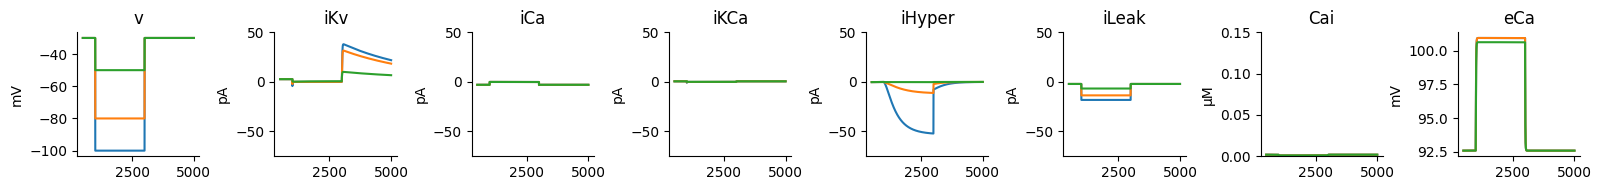

In [3]:
to_records = ["v", "iCa", "iKCa", "iLeak", "iHyper", 'iKv', "Cai", "eCa"]
mosaic = [["v", "iKv", "iCa", "iKCa", "iHyper", "iLeak", "Cai", 'eCa']]

params = {
    "length": 10,
    "radius": 5,
    "capacitance": 33.,
    "v": -30,
    "CaPump_taur": 10, # ms
    "CaPump_cainf": 0.001, # mM
    "Cao": 2.5, # mM
}

fig, ax = plt.subplot_mosaic(mosaic, figsize=(16, 2))

V_steps = [-100, -80, -50] # hyperpolarizing
# V_steps = [-30]
for v_step in V_steps:

    cell = Compartment()
    cell.insert(Kv())
    cell.insert(KA())
    cell.insert(Hyper())
    cell.insert(Ca())
    cell.insert(KCa())
    cell.insert(CaPump())
    cell.insert(CaNernstReversal())
    cell.insert(Leak())

    for name, param in params.items():
        cell.set(name, param)

    cell.init_states()

    for rec in to_records:
        cell.record(rec, verbose=False)

    pre_vc_time = 1000  # ms
    vc_on_time = 2000  # ms
    total_time = 5000 # ms
    dt = 0.01 # ms, 
    time_steps = int(total_time / dt)

    v = jnp.zeros(time_steps) - 30.
    vc_on = int(pre_vc_time / dt)
    vc_off = int((pre_vc_time + vc_on_time) / dt)
    padding = int(500/dt)
    v = v.at[vc_on:vc_off].set(v_step)
    
    cell.clamp("v", v, verbose=False)

    s = jx.integrate(cell, delta_t=dt, t_max=total_time)
    s = prettify(s, to_records, dt)
    for i, rec in enumerate(to_records):
        ax[rec].set_title(rec)
        ax[rec].spines["top"].set_visible(False)
        ax[rec].spines["right"].set_visible(False)
        if rec == "CaPump_Cad" or rec == "Cas" or rec=="Cai":
            ax[rec].set_ylabel("μM")
            ax[rec].set_ylim(0, 0.15)
            ax[rec].plot(s["time"][vc_on-padding:vc_off+int(2500/dt)], s[rec][vc_on-padding:vc_off+int(2500/dt)])
        elif rec == "v" or rec == "eCa":
            ax[rec].set_ylabel("mV")
            ax[rec].plot(s["time"][vc_on-padding:vc_off+int(2500/dt)], s[rec][vc_on-padding:vc_off+int(2500/dt)])
        else:
            ax[rec].set_ylabel("pA")
            ax[rec].set_ylim(-75, 50)
            ax[rec].plot(s["time"][vc_on-padding:vc_off+int(2500/dt)], s[rec][vc_on-padding:vc_off+int(2500/dt)])

fig.tight_layout()

# Current clamp

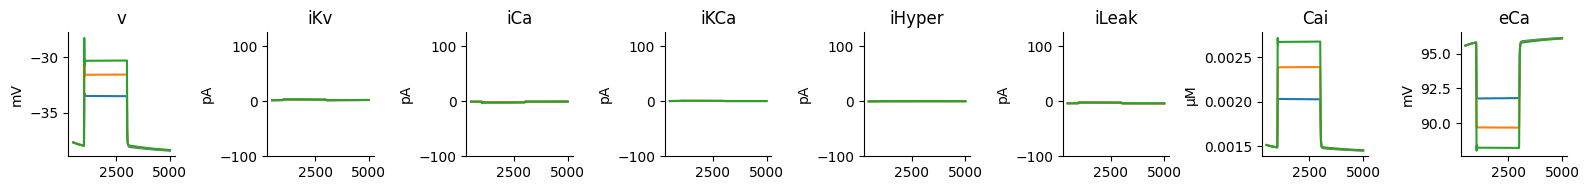

In [4]:
# to_records = ["v", "iCa", "iKCa", "iLeak", "iHyper", 'iKv', "iKA", "eCa", "Cai"]
# mosaic = [["v", "iKv", "iKA", "iCa", "iKCa"], ["iLeak", "iHyper", "eCa", "Cai", "."]]

to_records = ["v", "iCa", "iKCa", "iLeak", "iHyper", 'iKv', "Cai", "eCa"]
mosaic = [["v", "iKv", "iCa", "iKCa", "iHyper", "iLeak", "Cai", 'eCa']]

params = {
    "length": 5.,
    "radius": 2.5,
    "capacitance": 33.75,
    "v": -30,
    "CaPump_taur": 10,
    "CaPump_cainf": 0.001, # mM
    "Cao": 2.5,
}

fig, ax = plt.subplot_mosaic(mosaic, figsize=(16, 2))


i_dur = 2000
i_delay = 1000
i_offset = 0.0
# Duration and step size.
dt = 0.01  # ms
t_max = 5000  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

i_steps = [0.01, 0.02, 0.03]
for i_amp in i_steps:
    cell = Compartment()
    cell.insert(Kv())
    cell.insert(KA())
    cell.insert(Hyper())
    cell.insert(Ca())
    cell.insert(KCa())
    cell.insert(CaPump())
    cell.insert(CaNernstReversal())
    cell.insert(Leak())

    for name, param in params.items():
        cell.set(name, param)

    cell.init_states()

    for rec in to_records:
        cell.record(rec, verbose=False)

    current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max, i_offset=i_offset)
    cell.stimulate(current, verbose=False)  
    
    s = jx.integrate(cell, delta_t=dt, t_max=total_time)
    s = prettify(s, to_records, dt)

    padding = int(500/dt)

    for i, rec in enumerate(to_records):
        ax[rec].set_title(rec)
        ax[rec].spines["top"].set_visible(False)
        ax[rec].spines["right"].set_visible(False)
        if rec == "CaPump_Cad" or rec == "Cas" or rec=="Cai":
            ax[rec].set_ylabel("μM")
            # ax[rec].set_ylim(0, 0.15)
            ax[rec].plot(s["time"][vc_on-padding:vc_off+int(2500/dt)], s[rec][vc_on-padding:vc_off+int(2500/dt)])

        elif rec == "v" or rec == "eCa":
            ax[rec].set_ylabel("mV")
            ax[rec].plot(s["time"][vc_on-padding:vc_off+int(2500/dt)], s[rec][vc_on-padding:vc_off+int(2500/dt)])

        else:
            ax[rec].set_ylabel("pA")
            ax[rec].set_ylim(-100, 125)
            ax[rec].plot(s["time"][vc_on-padding:vc_off+int(2500/dt)], s[rec][vc_on-padding:vc_off+int(2500/dt)])

fig.tight_layout()

The same problem as in the voltage clamp: the calcium current is not as strong as the one reported in the paper.

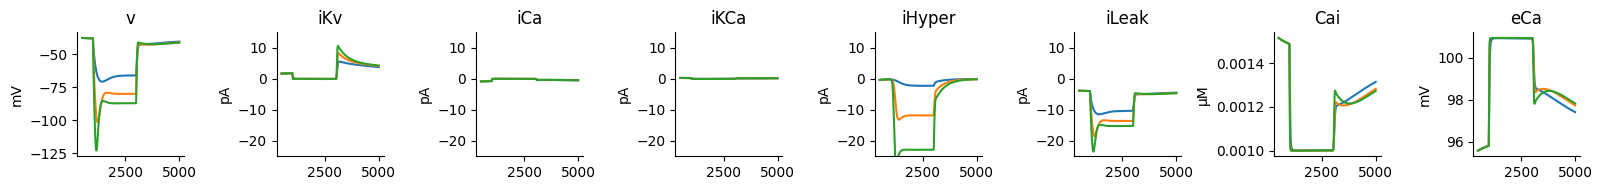

In [5]:
to_records = ["v", "iCa", "iKCa", "iLeak", "iHyper", 'iKv', "Cai", "eCa"]
mosaic = [["v", "iKv", "iCa", "iKCa", "iHyper", "iLeak", "Cai", "eCa"]]

params = {
    "length": 5.,
    "radius": 2.5,
    "capacitance": 33.75,
    "v": -30,
    "CaPump_taur": 10,
    "CaPump_cainf": 0.001, # mM
    "Cao": 2.5,
}

fig, ax = plt.subplot_mosaic(mosaic, figsize=(16, 2))


i_dur = 2000
i_delay = 1000
i_offset = 0.0
# Duration and step size.
dt = 0.01  # ms
t_max = 5000  # ms

time_vec = jnp.arange(0.0, t_max+dt, dt)

i_steps = [-0.01, -0.02, -0.03]
for i_amp in i_steps:
    cell = Compartment()
    cell.insert(Kv())
    cell.insert(KA())
    cell.insert(Hyper())
    cell.insert(Ca())
    cell.insert(KCa())
    cell.insert(CaPump())
    cell.insert(CaNernstReversal())
    cell.insert(Leak())

    for name, param in params.items():
        cell.set(name, param)

    cell.init_states()

    for rec in to_records:
        cell.record(rec, verbose=False)

    current = jx.step_current(i_delay, i_dur, i_amp, dt, t_max, i_offset=i_offset)
    cell.stimulate(current, verbose=False)  
    
    s = jx.integrate(cell, delta_t=dt, t_max=total_time)
    s = prettify(s, to_records, dt)

    for i, rec in enumerate(to_records):
        ax[rec].set_title(rec)
        ax[rec].spines["top"].set_visible(False)
        ax[rec].spines["right"].set_visible(False)
        if rec == "CaPump_Cad" or rec == "Cas" or rec=="Cai":
            ax[rec].set_ylabel("μM")
            # ax[rec].set_ylim(0, 0.15)
            ax[rec].plot(s["time"][vc_on-padding:vc_off+int(2500/dt)], s[rec][vc_on-padding:vc_off+int(2500/dt)])

        elif rec == "v" or rec == "eCa":
            ax[rec].set_ylabel("mV")
            ax[rec].plot(s["time"][vc_on-padding:vc_off+int(2500/dt)], s[rec][vc_on-padding:vc_off+int(2500/dt)])

        else:
            ax[rec].set_ylabel("pA")
            ax[rec].set_ylim(-25, 15)
            ax[rec].plot(s["time"][vc_on-padding:vc_off+int(2500/dt)], s[rec][vc_on-padding:vc_off+int(2500/dt)])

fig.tight_layout()

In [6]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p jaxley_mech

Last updated: 2024-07-09 18:10:30CEST

Python implementation: CPython
Python version       : 3.10.13
IPython version      : 8.21.0

jaxley_mech: 0.0.1

jax       : 0.4.26
jaxley    : 0.0.0
matplotlib: 3.8.3

Watermark: 2.4.3

